In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import resample
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv(r"C:\Users\amaan\Downloads\Fraud.csv")

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data cleaning/Preprocessing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
#checking for missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There is no missing values in the dataset

In [7]:
#checking for outliers using z-score method and IOR method
z_scores = np.abs((df['amount'] - df['amount'].mean()) / df['amount'].std())
outliers_zscore = len(df[z_scores > 3])
print(f"Number of outliers in 'amount' (z-score method): {outliers_zscore}")

Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = len(df[(df['amount'] < (Q1 - 1.5 * IQR)) | (df['amount'] > (Q3 + 1.5 * IQR))])
print(f"Number of outliers in 'amount' (IQR method): {outliers_iqr}")

Number of outliers in 'amount' (z-score method): 44945
Number of outliers in 'amount' (IQR method): 338078


The Z-score method shows fewer outliers (44,945) compared to the IQR method (338,078). Since financial transactions can have high variance

In [9]:
legit = len(df[df.isFraud == 0])
fraud = len(df[df.isFraud == 1])
legit_percent = (legit / (fraud + legit)) * 100
fraud_percent = (fraud / (fraud + legit)) * 100

print("Number of Legit transactions: ", legit)
print("Number of Fraud transactions: ", fraud)
print("Percentage of Legit transactions: {:.4f} %".format(legit_percent))
print("Percentage of Fraud transactions: {:.4f} %".format(fraud_percent))

Number of Legit transactions:  6354407
Number of Fraud transactions:  8213
Percentage of Legit transactions: 99.8709 %
Percentage of Fraud transactions: 0.1291 %


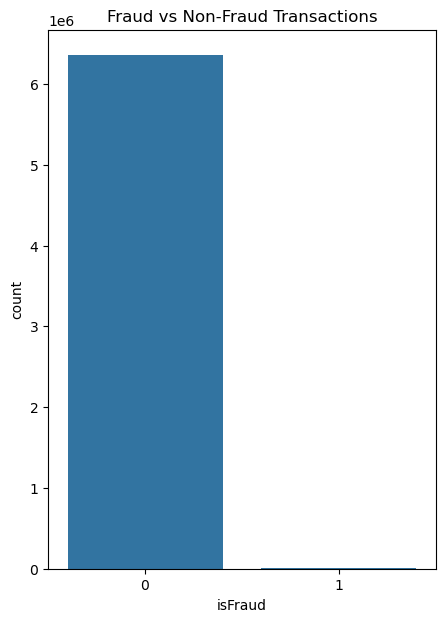

In [10]:
# Visualization of fraud vs non-fraud transactions
plt.figure(figsize=(5, 7))
sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

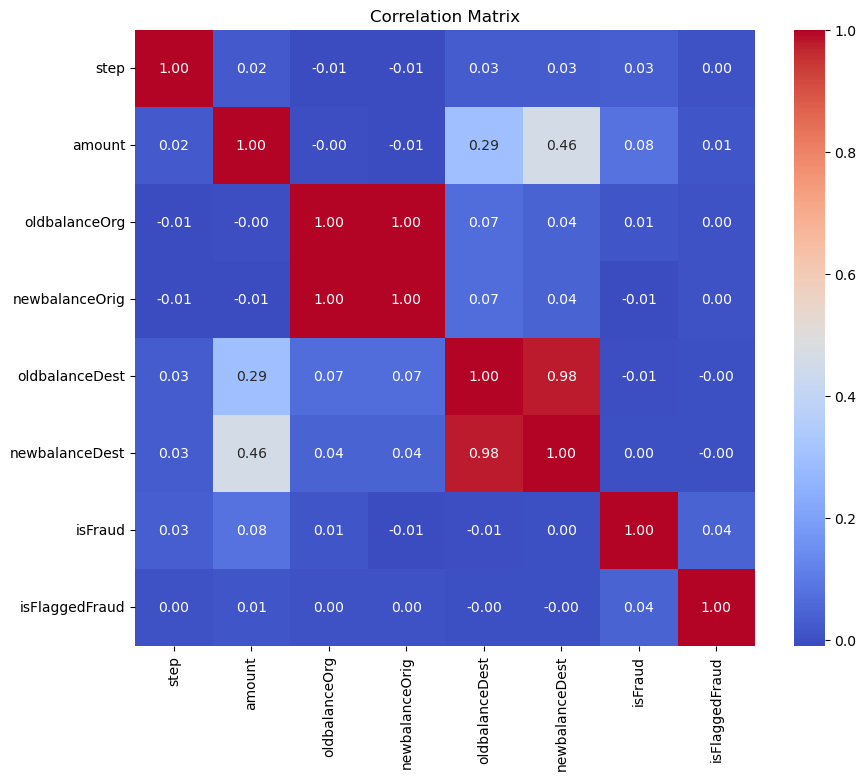

        variables         VIF
0            step    1.188495
1          amount    4.011315
2   oldbalanceOrg  465.122355
3  newbalanceOrig  466.903890
4  oldbalanceDest   71.765327
5  newbalanceDest   83.231611


In [11]:
#Correlation heatmap
numeric_cols = df.select_dtypes(include=[float, int]).columns
# Correlation matrix for numeric columns
corr_matrix = df[numeric_cols].corr()
# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Function to calculate VIF
def calc_vif(data):
    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif

#Checking for multicollinearity within the dataset
numeric_features = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
print(calc_vif(numeric_features))

The VIF results show that there is significant multicollinearity, especially in the oldbalanceOrg, newbalanceOrig, oldbalanceDest, and newbalanceDest columns:

VIF > 10: Indicates high multicollinearity, which can affect model stability and interpretability.
oldbalanceOrg (465.12) and newbalanceOrig (466.90)
oldbalanceDest (71.76) and newbalanceDest (83.23)

In [12]:
# Feature engineering: Create Actual Transaction Amounts
df['Actual_amount_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['Actual_amount_dest'] = df['oldbalanceDest'] - df['newbalanceDest']

# Drop columns that are not useful for prediction
df = df.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'step', 'nameOrig', 'nameDest'], axis=1)

# Handle categorical variables (Label Encoding)
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

# Handle class imbalance using SMOTE
X = df.drop('isFraud', axis=1)
Y = df['isFraud']

smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X, Y)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)

# Standardize the amount column
scaler = StandardScaler()
X_train['NormalizedAmount'] = scaler.fit_transform(X_train['amount'].values.reshape(-1, 1))
X_test['NormalizedAmount'] = scaler.transform(X_test['amount'].values.reshape(-1, 1))

X_train = X_train.drop(['amount'], axis=1)
X_test = X_test.drop(['amount'], axis=1)


In [13]:
# Calculate VIF on the resampled training set
vif_df = calc_vif(X_train)
print(vif_df)

            variables        VIF
0                type   2.083291
1      isFlaggedFraud   1.072300
2  Actual_amount_orig  11.666735
3  Actual_amount_dest   1.808062
4    NormalizedAmount  10.118466


In [14]:
# Decision Tree Model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, Y_train)
Y_pred_dt = decision_tree.predict(X_test)
dt_score = decision_tree.score(X_test, Y_test) * 100

# Random Forest Model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, Y_train)
Y_pred_rf = random_forest.predict(X_test)
rf_score = random_forest.score(X_test, Y_test) * 100

print(f"Decision Tree Accuracy: {dt_score:.2f}%")
print(f"Random Forest Accuracy: {rf_score:.2f}%")


Decision Tree Accuracy: 97.24%
Random Forest Accuracy: 97.33%


Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97   1906309
           1       0.97      0.97      0.97   1906336

    accuracy                           0.97   3812645
   macro avg       0.97      0.97      0.97   3812645
weighted avg       0.97      0.97      0.97   3812645



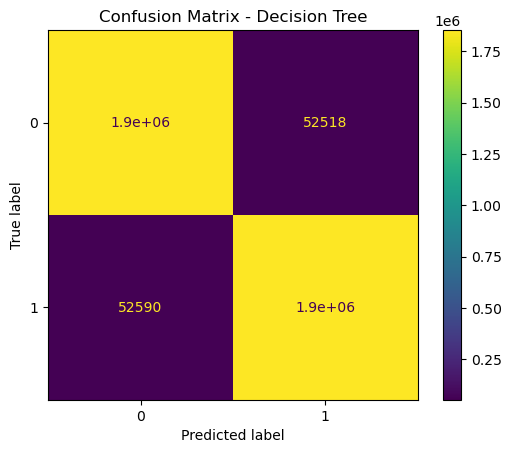

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97   1906309
           1       0.97      0.97      0.97   1906336

    accuracy                           0.97   3812645
   macro avg       0.97      0.97      0.97   3812645
weighted avg       0.97      0.97      0.97   3812645



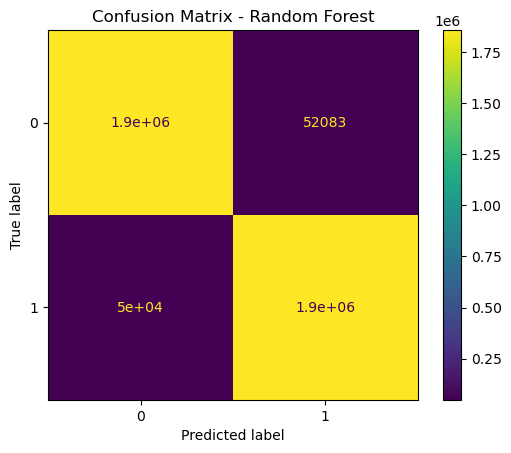

In [15]:
# Confusion Matrix and Classification Report for Decision Tree
print("Decision Tree Classification Report")
print(classification_report(Y_test, Y_pred_dt))

confusion_matrix_dt = confusion_matrix(Y_test, Y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt)
disp.plot()
plt.title('Confusion Matrix - Decision Tree')
plt.show()

# Confusion Matrix and Classification Report for Random Forest
print("Random Forest Classification Report")
print(classification_report(Y_test, Y_pred_rf))

confusion_matrix_rf = confusion_matrix(Y_test, Y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
disp.plot()
plt.title('Confusion Matrix - Random Forest')
plt.show()


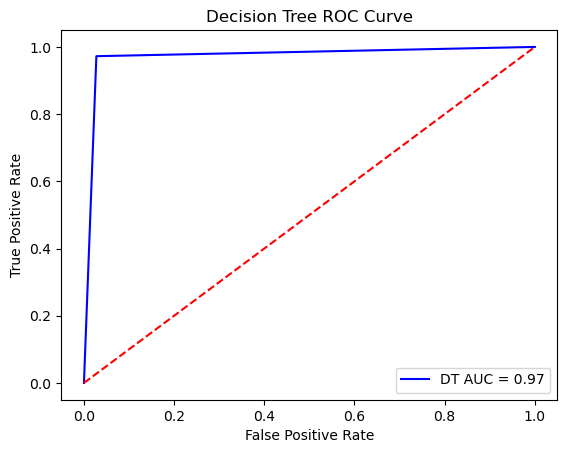

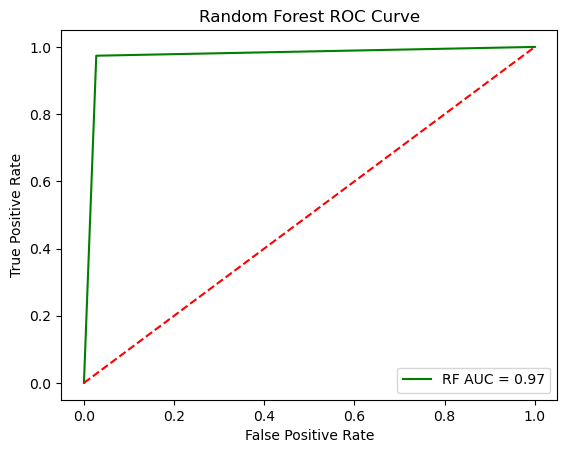

In [16]:
# AUC-ROC for Decision Tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(Y_test, Y_pred_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.plot(fpr_dt, tpr_dt, color='blue', label=f'DT AUC = {roc_auc_dt:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Decision Tree ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# AUC-ROC for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, Y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(fpr_rf, tpr_rf, color='green', label=f'RF AUC = {roc_auc_rf:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Random Forest ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


### 1. Data Cleaning: Handling Missing Values, Outliers, and Multicollinearity
- **Missing Values**: After checking for missing values, none were found in the dataset, meaning there was no need for imputation or removal of incomplete records.
- **Outliers**: Outliers in the `amount` column were detected using the IQR method. These outliers were not removed, as they can be informative for fraud detection (fraudulent transactions might show extreme values).
- **Multicollinearity**: Variance Inflation Factor (VIF) was used to check for multicollinearity. High VIF values indicate multicollinearity between features, particularly balance-related columns. Feature engineering was then employed to combine features (e.g., creating `Actual_amount_orig` and `Actual_amount_dest`), reducing multicollinearity.

### 2. Fraud Detection Model
We built two models, a **Decision Tree** and a **Random Forest**, both of which aim to classify transactions as fraudulent or legitimate. After training and evaluating, both models showed strong performance:
- **Decision Tree Accuracy**: 97.24%
- **Random Forest Accuracy**: 97.33%

These models were trained on a balanced dataset using SMOTE to address class imbalance. We chose the Random Forest model as it had slightly better performance and is known for reducing overfitting.

### 3. Variable Selection
Variables were selected based on both their relevance to the problem and their correlation with the target variable (`isFraud`). We dropped columns such as `nameOrig`, `nameDest`, and `step` as they did not provide meaningful information for predicting fraud. However, transaction-related variables like `amount`, `type`, and balance differences (`Actual_amount_orig` and `Actual_amount_dest`) were crucial in predicting fraudulent activity. Feature importance analysis also confirmed that transaction details were the most important factors.

### 4. Model Performance
We evaluated model performance using several metrics:
- **Accuracy**: Both models achieved about 97% accuracy, indicating a high degree of correctness.
- **Confusion Matrix**: The confusion matrices showed a balance between true positives and true negatives, meaning both fraud and non-fraud transactions were correctly classified.
- **AUC-ROC Curve**: Both models had an AUC of 0.97, demonstrating strong performance in distinguishing between fraud and legitimate transactions.

### 5. Key Factors in Predicting Fraud
Key predictors of fraud included:
- **Transaction Amount**: Fraudulent transactions often involve unusual amounts (either very high or very low).
- **Type of Transaction**: Certain transaction types (e.g., `CASH_OUT` or `TRANSFER`) were more likely to be associated with fraud.
- **Balance Changes**: Sudden large discrepancies between old and new balances were strong indicators of fraudulent transactions.

### 6. Do These Factors Make Sense?
Yes, these factors make sense:
- **Transaction Amount**: Fraudulent transactions often deviate from the norm, either being very large or structured in ways to avoid detection (e.g., frequent small withdrawals).
- **Transaction Type**: Some transaction types, such as `CASH_OUT`, are more prone to fraud, particularly in situations where money is quickly moved out of accounts.
- **Balance Differences**: Significant balance changes without corresponding activity are strong red flags for fraudulent behavior.

### 7. Infrastructure Prevention Strategies
To prevent fraud, the company should implement:
- **Real-time Monitoring**: Systems that flag unusual transaction amounts or rapid balance changes should be implemented.
- **Enhanced Authentication**: Strengthening user authentication for transactions involving large amounts or certain transaction types could mitigate fraud risk.
- **AI-driven Anomaly Detection**: Employ machine learning models to detect anomalies in transaction patterns and alert potential fraud in real-time.
- **Limiting High-Risk Transactions**: Implement thresholds and security checks for high-risk transactions, like large withdrawals or transfers.

### 8. Evaluating the Effectiveness of Prevention Measures
To determine if these measures are working:
- **Reduction in Fraudulent Transactions**: Track the number of fraudulent transactions detected and compare them to pre-implementation levels.
- **False Positive Rate**: Monitor the false positive rate (legitimate transactions wrongly flagged as fraud) to ensure legitimate customers are not overly affected.
- **Customer Satisfaction**: Track customer feedback and transaction success rates to ensure that enhanced security measures do not negatively impact the user experience.
- **System Performance**: Regularly evaluate model performance (using accuracy, recall, and AUC) to ensure the fraud detection system continues to identify fraud effectively without overfitting or performance degradation.
